<a href="https://colab.research.google.com/github/bgohrani/ML_Projects/blob/main/California_Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

#Importing essential Libraries

## 1. Loading the Data

In [151]:
housing_data = pd.read_csv('housing.csv')
housing_data.head()

#Importing the housing data and using Pandas to read it 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [152]:
housing_data.info()

#Information on the datatypes of the attributes of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 2. Splitting & Visualization

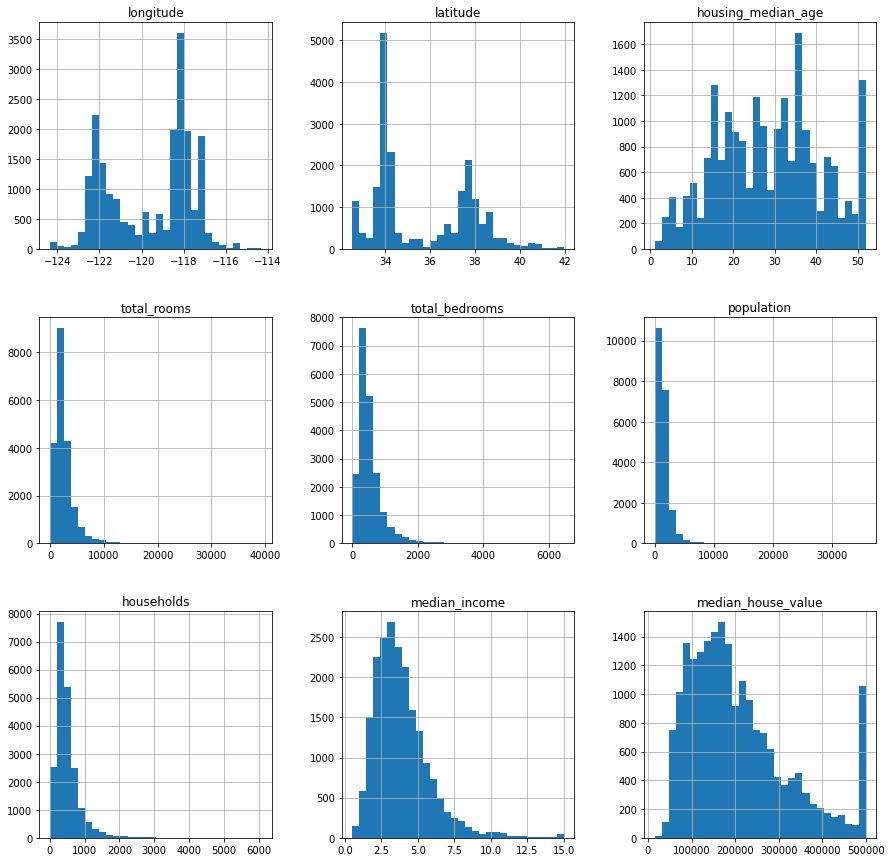

In [153]:
housing_data.hist(figsize=(15,15),bins=30)
plt.show()

#Here we wish to see the distribution of the data across each attribute, so we use the hist function of Pandas
#Visualiztion is performed through Matplotlib

In [154]:
new_column_data = housing_data['median_income'].to_numpy()
new_column = np.zeros(new_column_data.shape)

#We wish to study the correlation between income and house value
#We also need to split the data into training and testing sets 
#We need to ensure that the income categories are evenly distrubed amongst the training and test sets

In [155]:
for i,value in enumerate(new_column_data):
  if value > 0 and value <= 1.5: new_column[i] = 1 
  elif value > 1.5 and value <= 3: new_column[i] = 2 
  elif value > 3 and value <= 4.5: new_column[i] = 3 
  elif value > 4.5 and value <= 6: new_column[i] = 4 
  else: new_column[i] = 5

#We split the income into 5 different categories

In [156]:
housing_data['income_categories'] = new_column

#These categorical income data is added to the housing data

In [157]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_categories
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [158]:
training_data, test_data = train_test_split(housing_data,test_size = 0.2, random_state = 0, stratify=housing_data['income_categories'])

#We then split the data, stratifying it across income to ensure uniform representation

In [159]:
del training_data['income_categories']
del test_data['income_categories']

#Once we have split, it is safe to delete the income categories

In [160]:
training_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19328,-122.87,38.48,27.0,3894.0,776.0,1832.0,715.0,3.5085,187800.0,<1H OCEAN
4806,-118.34,34.02,49.0,1609.0,371.0,896.0,389.0,2.5156,136600.0,<1H OCEAN
15645,-122.42,37.79,52.0,3364.0,1100.0,2112.0,1045.0,2.1343,400000.0,NEAR BAY
2975,-119.08,35.32,8.0,11609.0,2141.0,5696.0,2100.0,5.0012,106300.0,INLAND
18823,-121.62,41.78,40.0,3272.0,663.0,1467.0,553.0,1.7885,43500.0,INLAND


In [161]:
housing_training = training_data.copy()

#We create a copy for visualization

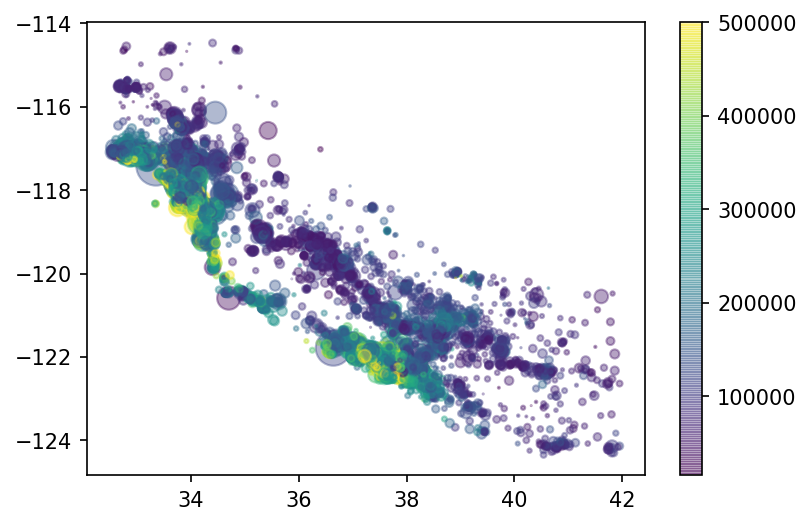

In [162]:
plt.figure(dpi=150)
plt.scatter(housing_training['latitude'], housing_training['longitude'], s=housing_training['population']/100, c = housing_training['median_house_value'], alpha=0.4)
plt.colorbar()
plt.show()

#We want to see the geographical distribution of the houses
#we make a scatter plot of latitude and longitude and see a shape similar to California
#Setting alpha also allows us to view regions with high density

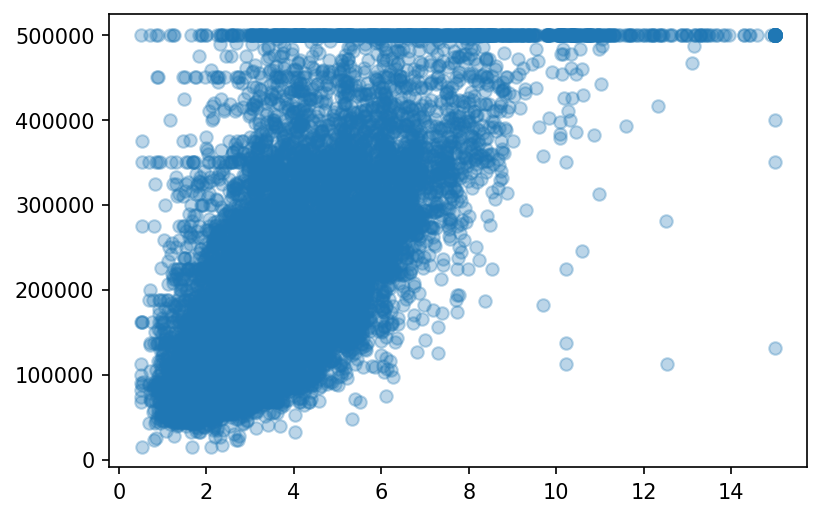

In [163]:
plt.figure(dpi=150)
plt.scatter(housing_training['median_income'],housing_training['median_house_value'], alpha=0.3)
plt.show()

#Plotting income vs house value shows a strong positive correlation, values are capped at a max of 500,000

## 3. Data Transformation

In [164]:
housing = housing_training.drop('median_house_value', axis = 1)
housing_labels = housing_training['median_house_value']

#We drop the label of median_house_value since that is what we want to predict

In [188]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class Add_Modified_Attributes(BaseEstimator, TransformerMixin):
  def __init__(self):
    return
  def fit(self,X, y=None):
    return self
  def transform(self, X, y =None):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
    return np.c_[X, rooms_per_household, population_per_household,
    bedrooms_per_room]

#This Add_Modified_Attributes class helps us to add three more attibutes, which are:
#rooms_per_household, population_per_household, bedrooms_per_room
#These can help in better training

In [189]:
numerical_columns = list(housing)
numerical_columns.pop()

#The ocean_proximity is the only categorical variable, so we create a list of all categories except it

'ocean_proximity'

In [191]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('new_attribute_adder', Add_Modified_Attributes()),
                         ('standard_scaling', StandardScaler())
])

numerical_columns = numerical_columns
categorical_columns = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ('numerical_transform', num_pipeline, numerical_columns),
                                   ('categorical_transform', OrdinalEncoder(), categorical_columns)
])

prepared_housing_data = full_pipeline.fit_transform(housing)

#Here is the most important element of our project, the Data Transformation and processing pipelines
#We create a numerical pipeline which accomplishes the following:
#   - Uses the Sklearn SimpleImputer, replacing NaN values with the median
#   - Uses the Add_Modified_Attributes class to add the extra attributes
#   - Standardizes the data for even and smooth training
#The numerical pipeline acts on all classes except the ocean_proximity

#The full pipeline uses Sklearn's column transformer to merge pipelines and create an entire transformation process
#   - Calls the numerical pipeline for the numerical columns only
#   - Calls a Encoding transformation for the ocean_proximity attribute

#A numpy array with data ready for training is returned

## 4. Training the Model

In [192]:
linear_reg = LinearRegression()
linear_reg.fit(prepared_housing_data, housing_labels)

#Training a Linear Regression model 

LinearRegression()

In [193]:
random_value = int(np.random.random()*prepared_housing_data.shape[0])
sample_data = prepared_housing_data[random_value:random_value+25]
sample_labels = housing_labels[random_value: random_value+25]

#Creating sample data from the training data to compute loss

In [194]:
predicted_labels = linear_reg.predict(sample_data)

#Predicting on the sample data

In [195]:
squared_error = mean_squared_error(sample_labels, predicted_labels)
rms_error = math.sqrt(squared_error)
print(rms_error)

#Loss calculation in the form of Root Mean Squared Error
#High loss, underfitting of the data, very simple model

62397.54516669988


In [196]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(prepared_housing_data, housing_labels)

#Using the decision tree model

DecisionTreeRegressor()

In [197]:
predicted_tree_labels = decision_tree.predict(sample_data)
squared_error_tree = mean_squared_error(sample_labels, predicted_tree_labels)
rms_error_tree = math.sqrt(squared_error_tree)
print(rms_error_tree)

#Predicting and computing loss
#0.0 loss, extremely high Overfitting

0.0


In [198]:
scores_cross_validation = cross_val_score(decision_tree, prepared_housing_data, housing_labels, scoring='neg_mean_squared_error', cv = 10)
tree_scores = np.sqrt(-scores_cross_validation)
print(tree_scores)

#Using cross validation by dividing the data into parts
#Reasonable loss, similar to linear regression

[69392.14051439 73048.49123005 71456.65018748 67784.70392028
 74974.47683649 72322.87946119 70007.29335746 72523.36136355
 69506.17946661 71077.8405346 ]


In [199]:
random_forest = RandomForestRegressor()
random_forest.fit(prepared_housing_data, housing_labels)

#Random Forest Model

RandomForestRegressor()

In [200]:
predicted_forest_labels = random_forest.predict(sample_data)
squared_error_forest = mean_squared_error(sample_labels, predicted_forest_labels)
rms_error_forest = math.sqrt(squared_error_forest)
print(rms_error_forest)

#Prediction and loss computation
#Lower loss, better model for use

12951.288825561727


In [201]:
scores_cross_validation_forest = cross_val_score(random_forest, prepared_housing_data, housing_labels, scoring='neg_mean_squared_error', cv = 10)
forest_scores = np.sqrt(-scores_cross_validation_forest)
print(forest_scores)

#Cross validation with Random Forest, lower loss than previous 
#Still signs of moderate overfitting

[48223.95634493 53113.90246162 51261.3537625  50670.86464397
 52335.49815389 48386.97518697 50026.15760435 49559.98610599
 52357.62328392 50795.396465  ]


In [202]:
parameters_to_tune = [
                      {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
                      {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_regression_search = RandomForestRegressor()

grid_search = GridSearchCV(forest_regression_search, parameters_to_tune,scoring = 'neg_mean_squared_error', cv = 5, return_train_score=True)
grid_search.fit(prepared_housing_data, housing_labels)

#Hyperparameter Tuning
#We create a Random Forest Regressor and use Sklearn's grid search for combinatons of hyperparameters 

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [203]:
grid_search.best_params_

#Best parameters after tuning

{'max_features': 4, 'n_estimators': 30}

In [204]:
grid_search.best_estimator_.feature_importances_

#Relative importance of attributes towards prediction

array([0.09713288, 0.09823249, 0.04499839, 0.01942275, 0.01816369,
       0.01941323, 0.0183745 , 0.33944113, 0.08148953, 0.11220663,
       0.08436456, 0.06676022])

In [205]:
final_model = grid_search.best_estimator_

#Selecting the best model

In [206]:
test_labels = test_data['median_house_value']
test_data_modified = test_data.drop('median_house_value', axis =1)

#Separating the labels from the Test data

In [208]:
prepared_testing_data = full_pipeline.fit_transform(test_data_modified)

#Passing the test data through our transformation pipeline

In [209]:
final_prediction = final_model.predict(prepared_testing_data)

#Predicting with the tuned Random Forest Model 

In [210]:
final_mse = mean_squared_error(test_labels, final_prediction)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

#Final Loss on the model, improved performance

52216.46935755928
